In [57]:
from langgraph.graph import StateGraph,START,END
from langchain_google_genai import  ChatGoogleGenerativeAI
from typing import TypedDict,Literal
from dotenv import load_dotenv
import os
from pydantic import BaseModel,Field


In [58]:
load_dotenv()

True

In [59]:
model = ChatGoogleGenerativeAI(
    model = os.getenv("GEMINI_MODEL"),
    api_key = os.getenv("Google_API_KEY")
)

In [60]:
# schema for structured output
class SentimentSchema(BaseModel):
    sentiment : Literal["positive","negative"] = Field(description = "Sentiment of the review")
    


In [61]:
#another schema for structured output 
class DiagnosisSchema(BaseModel):
    issue_type : Literal["UX","Performance","Bug","Support","Other"] = Field(description = 'The category of issue mentioned in the review')
    tone: Literal["angry","frustated","disappointed","calm"] = Field(description = 'The emotional tone expressed by the user')
    urgency: Literal["Low","Medium","High"] = Field(description = 'How urgeny or critical the issue appears to be ')

In [62]:
structured_model = model.with_structured_output(SentimentSchema)
structured_model1 = model.with_structured_output(DiagnosisSchema)

In [63]:
prompt =f"What is the sentiment of the following review - The software is too bad"

structured_model.invoke(prompt)

SentimentSchema(sentiment='negative')

In [64]:
structured_model.invoke(prompt).sentiment

'negative'

In [65]:
# create a state
class ReviewState(TypedDict):
    review : str
    sentiment : Literal["positive","negative"]
    diagnosis : dict
    response : str
    


In [66]:
def find_sentiment(state:ReviewState):
    review = state['review']
    prompt = f"What is the sentiment of the review {review}"
    sentiment = structured_model.invoke(prompt).sentiment
    return {'sentiment': sentiment}


def check_Sentiment(state: ReviewState) -> Literal["positive_response","run_diagnosis"]:
    if state['sentiment'] == "positive":
        return "positive_response"
    else:
        return "run_diagnosis"
    
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank-you mesage in response to this review: \n\n\"{state['review']}\"\n also,kindly ask the user to leave feedback on our website."""

    response = model.invoke(prompt).content
    return {'response' : response}


def run_diagnosis(state : ReviewState):
    prompt = f'Diagnose this negative review: {state['review']} Return issue_type, tone and urgency."'

    response = structured_model1.invoke(prompt)

    return {'diagnosis':response.model_dump()} #as response is in json as it is a pydantic object if we use model_dump then it will convert into dictionary.
 

def negative_response(state:ReviewState):
    diagnosis = state['diagnosis']
    prompt = f'You are a support assistant. The user had a \'{diagnosis['issue_type']}\' issue, sounded \'{diagnosis['tone']}\', and marked urgency as \'{diagnosis['urgency']}\' Write an empathetic, helpful resolution message.'
    response = model.invoke(prompt)
    return {'response' : response}



In [67]:
# create a graph
graph = StateGraph(ReviewState)

# create nodes
graph.add_node('find_sentiment',find_sentiment)
graph.add_node('positive_response',positive_response)
graph.add_node('run_diagnosis',run_diagnosis)
graph.add_node('negative_response',negative_response)


# create edges
graph.add_edge(START,'find_sentiment')
graph.add_conditional_edges('find_sentiment',check_Sentiment)
graph.add_edge('positive_response',END)
graph.add_edge('run_diagnosis','negative_response')
graph.add_edge('negative_response',END)

# compile
workflow = graph.compile()
# execute
intial_state={'review' : 'This dress is very good'}
workflow.invoke(intial_state)

{'review': 'This dress is very good',
 'sentiment': 'positive',
 'response': "Subject: Thank you for your review!\n\nHi there,\n\nThank you so much for your positive review of the dress! We're so glad you think it's very good. We really appreciate you taking the time to share your experience.\n\nIf you have a moment, we'd love to hear more about what you particularly liked about the dress on our website: [Link to your website review page - optional]. Your feedback helps us continue to improve and provide the best possible products and service.\n\nThanks again!\n\nSincerely,\n\nThe [Your Company Name] Team"}

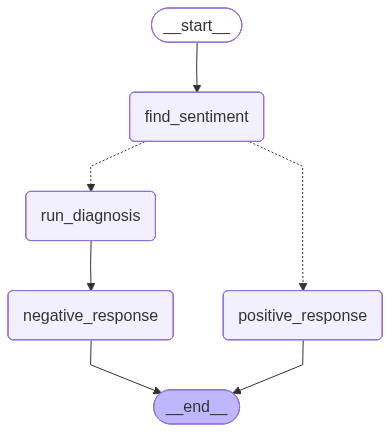

In [68]:
workflow